# Analysis of Human Hippocampal Neurons During Working Memory

**Warning**: This notebook was generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results.

## Dataset Overview

This notebook explores Dandiset 000673: "Data for: Control of working memory by phase–amplitude coupling of human hippocampal neurons". The dataset contains electrophysiological recordings and behavioral data from patients with intracranial electrodes performing a Sternberg working memory task.

**Key Features:**
- Recordings from human medial temporal and frontal lobe
- Single neuron activity and local field potentials (LFPs)
- Working memory task with varying memory loads
- Focus on theta-gamma phase-amplitude coupling

## Required Packages

To run this notebook, you'll need the following packages installed:
- pynwb
- lindi
- numpy
- matplotlib
- seaborn
- scipy

In [1]:
# Import required packages
import pynwb
import lindi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from collections import Counter

# Set up plotting style
sns.set_theme()

## Loading the Dataset

First, let's use the DANDI API to list all assets in the dataset and then load our example subject's data.

In [2]:
# List all assets in the dataset
from dandi.dandiapi import DandiAPIClient
client = DandiAPIClient()
dandiset = client.get_dandiset("000673")
assets = list(dandiset.get_assets())

print(f"Total number of NWB files: {len(assets)}")
print("\nFirst few files:")
for asset in assets[:5]:
    print(f"- {asset.path}")

Total number of NWB files: 44

First few files:
- sub-11/sub-11_ses-1_ecephys+image.nwb
- sub-12/sub-12_ses-1_ecephys+image.nwb
- sub-1/sub-1_ses-1_ecephys+image.nwb
- sub-1/sub-1_ses-2_ecephys+image.nwb
- sub-10/sub-10_ses-1_ecephys+image.nwb


In [3]:
# Load the first subject's data
f = lindi.LindiH5pyFile.from_lindi_file("https://lindi.neurosift.org/dandi/dandisets/000673/assets/65a7e913-45c7-48db-bf19-b9f5e910110a/nwb.lindi.json")
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

print("\nDataset Information:")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Session Start: {nwb.session_start_time}")
print(f"Experiment Description: {nwb.experiment_description}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."



Dataset Information:
Subject ID: 1
Session Start: 2018-01-01 00:00:00-08:00
Experiment Description: This data contains electrophysiological recordings and behavior from the Sternberg task performed in patients with intractable epilepsy implanted with depth electrodes and Behnke-Fried microwires in the human medial temporal lobe and medial frontal cortex.


## Behavioral Analysis

The experiment used a Sternberg working memory task where participants had to remember either 1 or 3 images. Let's analyze the behavioral performance across different memory loads.


Behavioral Performance Summary:
Memory Load 1: 100.0% accuracy
Memory Load 3: 94.3% accuracy


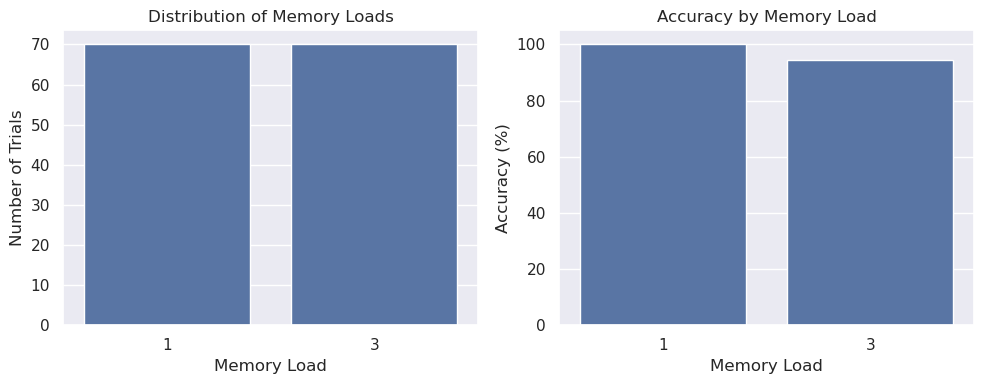

In [4]:
# Get trial information
trials = nwb.intervals["trials"]
loads = trials["loads"][:]
accuracy = trials["response_accuracy"][:]

# Plot distribution of memory loads
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
load_counts = Counter(loads)
sns.barplot(x=list(load_counts.keys()), y=list(load_counts.values()))
plt.title('Distribution of Memory Loads')
plt.xlabel('Memory Load')
plt.ylabel('Number of Trials')

# Plot accuracy by memory load
plt.subplot(1, 2, 2)
accuracy_by_load = {}
for load in np.unique(loads):
    load_mask = loads == load
    accuracies = accuracy[load_mask]
    accuracy_by_load[load] = np.mean(accuracies) * 100

sns.barplot(x=list(accuracy_by_load.keys()), y=list(accuracy_by_load.values()))
plt.title('Accuracy by Memory Load')
plt.xlabel('Memory Load')
plt.ylabel('Accuracy (%)')
plt.tight_layout()

print("\nBehavioral Performance Summary:")
for load, acc in accuracy_by_load.items():
    print(f"Memory Load {load}: {acc:.1f}% accuracy")

## Neural Activity Analysis

The dataset contains both single-unit recordings and local field potentials (LFPs). Let's examine both types of neural activity:
1. Single unit spike patterns
2. LFP activity during working memory maintenance

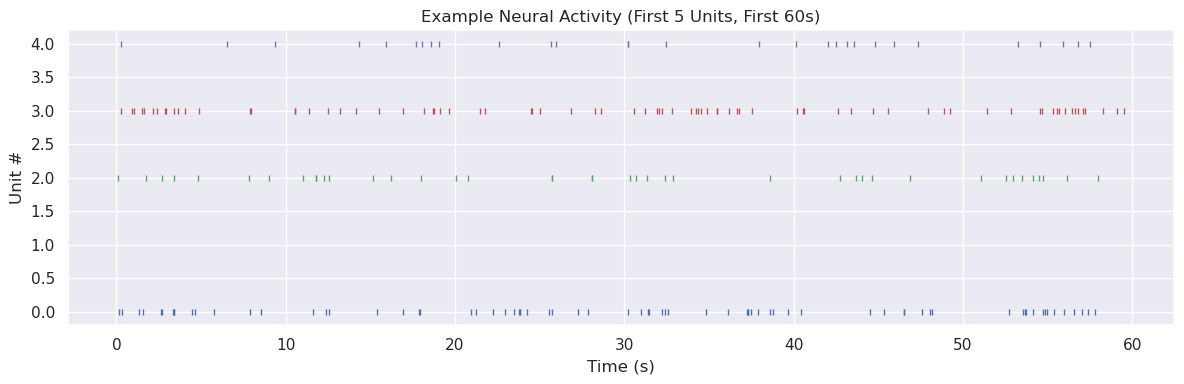

In [5]:
# Plot example neural activity for first few units
unit_ids = nwb.units["id"].data[:5]  # Get first 5 units
plt.figure(figsize=(12, 4))
plt.title('Example Neural Activity (First 5 Units, First 60s)')
plt.xlabel('Time (s)')
plt.ylabel('Unit #')

for i, unit_id in enumerate(unit_ids):
    spike_times = nwb.units["spike_times"][i]
    spike_times = spike_times[spike_times < 60]  # First 60 seconds
    plt.plot(spike_times, np.ones_like(spike_times) * i, '|', markersize=4)

plt.tight_layout()

## LFP Analysis During Working Memory

Now let's examine the LFP activity during the working memory maintenance period. We'll look at:
1. Raw LFP traces from multiple channels
2. Time-frequency analysis to examine oscillatory patterns


LFP Recording Information:
Number of LFP channels: 70
Sampling rate: 400.0 Hz
Recording duration: 1375.69 seconds


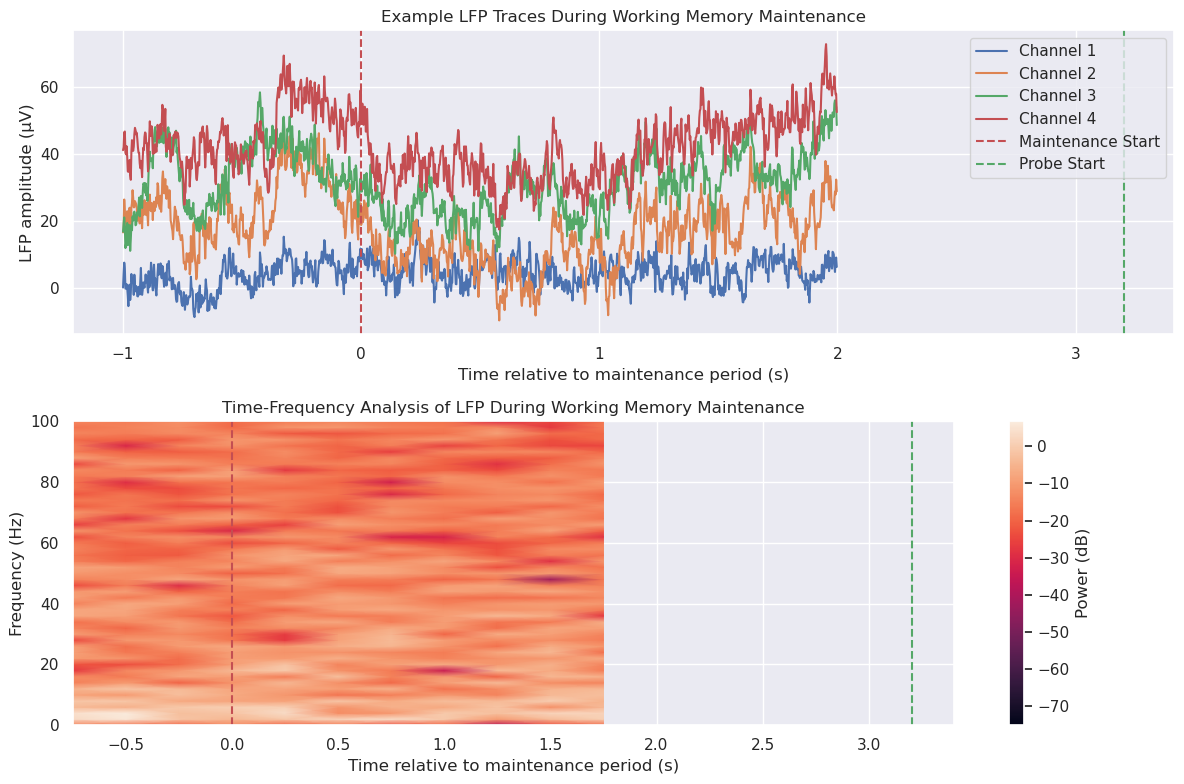

In [6]:
# Get LFP data
lfps = nwb.acquisition["LFPs"]
sampling_rate = lfps.rate

# Get example trial timestamps
example_trial_idx = 0  # Look at first trial
maintenance_start = trials["timestamps_Maintenance"][example_trial_idx]
probe_start = trials["timestamps_Probe"][example_trial_idx]

# Calculate time window
window_before = 1.0  # seconds before maintenance
window_after = 2.0   # seconds after maintenance

# Convert times to indices
start_idx = int((maintenance_start - window_before) * sampling_rate)
end_idx = int((maintenance_start + window_after) * sampling_rate)

# Get LFP data for this window (first few channels)
n_channels = 4
time = np.arange(start_idx, end_idx) / sampling_rate
lfp_data = lfps.data[start_idx:end_idx, :n_channels]

# Create figure
plt.figure(figsize=(12, 8))

# Plot raw LFP traces
plt.subplot(2, 1, 1)
for i in range(n_channels):
    offset = i * np.std(lfp_data[:, 0]) * 3
    plt.plot(time - maintenance_start, lfp_data[:, i] + offset, label=f'Channel {i+1}')

plt.axvline(x=0, color='r', linestyle='--', label='Maintenance Start')
plt.axvline(x=probe_start - maintenance_start, color='g', linestyle='--', label='Probe Start')
plt.xlabel('Time relative to maintenance period (s)')
plt.ylabel('LFP amplitude (μV)')
plt.title('Example LFP Traces During Working Memory Maintenance')
plt.legend()

# Time-frequency analysis
plt.subplot(2, 1, 2)
f, t, Sxx = signal.spectrogram(lfp_data[:, 0], fs=sampling_rate, 
                              nperseg=int(sampling_rate/2),
                              noverlap=int(sampling_rate/4))
plt.pcolormesh(t - window_before, f, 10 * np.log10(Sxx), shading='gouraud')
plt.axvline(x=0, color='r', linestyle='--', label='Maintenance Start')
plt.axvline(x=probe_start - maintenance_start, color='g', linestyle='--', label='Probe Start')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time relative to maintenance period (s)')
plt.title('Time-Frequency Analysis of LFP During Working Memory Maintenance')
plt.colorbar(label='Power (dB)')
plt.ylim(0, 100)
plt.tight_layout()

# Print some LFP information
print("\nLFP Recording Information:")
print(f"Number of LFP channels: {lfps.data.shape[1]}")
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Recording duration: {lfps.data.shape[0]/sampling_rate:.2f} seconds")

## Summary

This notebook demonstrated how to:
1. Load and access data from this human intracranial recording dataset
2. Analyze behavioral performance in the working memory task
3. Visualize single-unit neural activity
4. Examine LFP patterns during working memory maintenance

Key observations:
- The dataset contains recordings from multiple subjects performing a Sternberg working memory task
- Behavioral performance shows high accuracy with a slight decrease for higher memory loads
- Neural data includes both single-unit activity and LFP recordings
- LFP recordings show distinct oscillatory patterns during working memory maintenance

For more detailed analysis methods and the complete study findings, please refer to the associated paper and the code repository at: https://github.com/rutishauserlab/SBCAT-release-NWB